### Results For paper

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython
%reload_ext Cython

In [2]:
import sys
sys.path.append('../..')
sys.path.append('..')

import warnings
def warn(message, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.style.use('seaborn-paper')
from lifelines import KaplanMeierFitter
from diabetes_onset import survival_diabetes

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import lifelines
from lifelines import CoxPHFitter 
from lifelines import WeibullFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts, rmst_plot
from lifelines.utils import restricted_mean_survival_time



from diabetes_onset_plotter import survival_fit_res, make_results

In [3]:
np.random.seed(seed = 0)

### Load Data

In [4]:
%%time
p = '../tempHybridSelection/'
treated = pd.read_pickle(p+'treated0.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
controls = pd.read_pickle(p+'match0.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

treated['Treatment'] = 1
controls['Treatment'] = 0

CPU times: user 139 ms, sys: 69.2 ms, total: 208 ms
Wall time: 225 ms


### Optional(filter registrations after  a particular month and before a particular month)

In [5]:
def setfirst(group):
    group['First'] = group.MYR.iloc[0]
    return group

FILTER = False
if FILTER:
    treated = treated.groupby('PERS_ID').apply(lambda x: setfirst(x)).reset_index(drop = True)
    controls = controls.groupby('PERS_ID').apply(lambda x: setfirst(x)).reset_index(drop = True)

    month_filter_lower = 201711
    month_filter_upper = 202008
    myr_filt = (treated.First <= month_filter_upper) & (treated.First >= month_filter_lower)
    treated = treated[myr_filt].reset_index(drop = True)

    myr_filt = (controls.First <= month_filter_upper) & (controls.First >= month_filter_lower)
    controls = controls[myr_filt].reset_index(drop = True)


### Set common variables

In [6]:
filter_cols =  ['AGE_AT_MIDMONTH', 'MBR_GNDR', 'ALLOW_AMT','CC_TOBACCO',  'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'T', 'E']

log_normalize = ['ALLOW_AMT']
normalize = ['AGE_AT_MIDMONTH', 'CC_DX_CNT']
#normalize = ['AGE_AT_MIDMONTH', 'ALLOW_AMT']

model_type = 'kaplan'
model = KaplanMeierFitter
model_argsK = {}#{'timeline':24}# {"penalizer":0.001, 'alpha': 0.05}
model_args= {}
fit_args = {"step_size": 0.1, "show_progress":False}

timeline = 24
fit_args1 = {"timeline":np.arange(timeline)}
#put title in the figures 1 0 no
outcome_title = 1

kaplan_plot_params = {"show_censors": False, "ci_alpha":0.1, "ci_force_lines":False}# "at_risk_counts": False}

In [7]:
path_tabs = './res/tabs/'
path_figs = './res/figs/'
path_figs2 = './res/figs2' #plots without risk at count

#create paths if not created
from pathlib import Path
p1 = Path(path_tabs)
p2 = Path(path_figs)
p3 = Path(path_figs2)

p1.mkdir(parents = True, exist_ok = True)
p2.mkdir(parents = True, exist_ok = True)
p3.mkdir(parents = True, exist_ok = True)

In [8]:
filter_cols2 =  ['AGE_AT_MIDMONTH', 'MBR_GNDR', 'ALLOW_AMT','CC_TOBACCO', 'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'T', 'E', 'Treatment']

summary_names =  ['Age','Gender', 'Total Cost',  'Tobacco use',  'Obesity', 
            'Hypertension', 'Hypothyroid', 'Disease Count',  'Treatment']

### Diabetes

In [9]:
#treated[treated.PERS_ID == '2567120'][['MYR', 'ALLOW_IP', 'ALLOW_ER', 'Acute-bin']]

In [10]:
#survTr

In [11]:
%%time
after = 1
survTr = treated.copy().groupby('PERS_ID').apply(survival_diabetes, after = after).reset_index(drop = True)
survCo = controls.copy().groupby('PERS_ID').apply(survival_diabetes, after = after).reset_index(drop = True)


CPU times: user 3.5 s, sys: 23.8 ms, total: 3.52 s
Wall time: 3.52 s


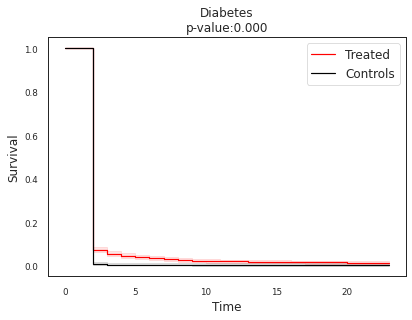

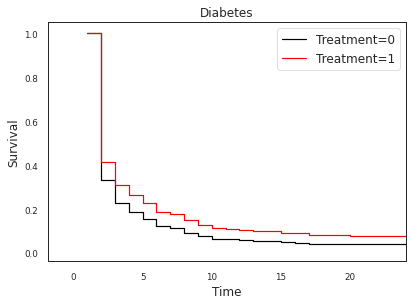

In [12]:
fitted, rmstD = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type = model_type,
                          model_args = model_argsK,fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Diabetes'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize, 
                                      kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline,
                                     outcome_title = outcome_title)

In [13]:
lrsumm

test_statistic             p   -log2(p)
Diabetes       26.131477  3.189421e-07  21.580202

In [14]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                 -0.184           0.151       -1.220    0.222
Gender               0.024           0.044        0.552    0.581
Total Cost           0.007           0.010        0.675    0.500
Tobacco use         -0.019           0.065       -0.295    0.768
Obesity             -0.044           0.050       -0.885    0.376
Hypertension         0.065           0.053        1.220    0.222
Hypothyroid         -0.036           0.076       -0.480    0.631
Disease Count        1.107           0.224        4.951    0.000
Treatment           -0.228           0.049       -4.696    0.000

### ER

In [15]:
data = [treated.copy(),  controls.copy()]
for d in data:
    d['ER-bin'] = (d['ALLOW_ER'] > 0).astype(int)

In [16]:
%%time
onset = 'ER-bin'

survTr = data[0].groupby('PERS_ID').apply(survival_diabetes,after = after, onset = onset).reset_index(drop = True)
survCo = data[1].groupby('PERS_ID').apply(survival_diabetes,after = after, onset = onset).reset_index(drop = True)


CPU times: user 3.43 s, sys: 36.7 ms, total: 3.47 s
Wall time: 3.47 s


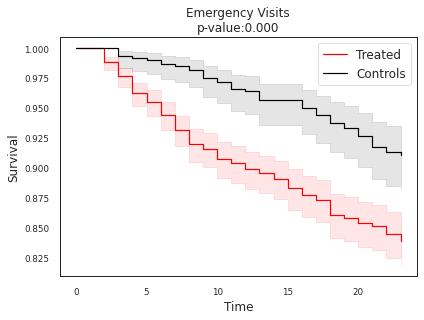

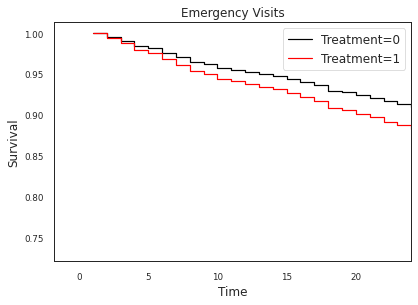

In [17]:
fitted, rmstER = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type =model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Emergency Visits'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names, 
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline,
                                      outcome_title = outcome_title)

In [18]:
lrsumm

test_statistic         p   -log2(p)
Emergency Visits        23.21897  0.000001  19.399858

In [19]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                 -2.410           0.343       -7.029    0.000
Gender              -0.457           0.103       -4.428    0.000
Total Cost           0.101           0.028        3.641    0.000
Tobacco use          0.554           0.121        4.564    0.000
Obesity             -0.368           0.112       -3.282    0.001
Hypertension        -0.034           0.122       -0.281    0.778
Hypothyroid         -0.152           0.157       -0.966    0.334
Disease Count        4.019           0.489        8.214    0.000
Treatment            0.277           0.126        2.204    0.028

### IP

In [20]:
data = [treated.copy(),  controls.copy()]
for d in data:
    d['IP-bin'] = (d['ALLOW_IP'] > 0).astype(int)

In [21]:
%%time
onset = 'IP-bin'

survTr = data[0].groupby('PERS_ID').apply(survival_diabetes,after = after,  onset = onset).reset_index(drop = True)
survCo = data[1].groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset).reset_index(drop = True)


CPU times: user 3.45 s, sys: 16 ms, total: 3.47 s
Wall time: 3.47 s


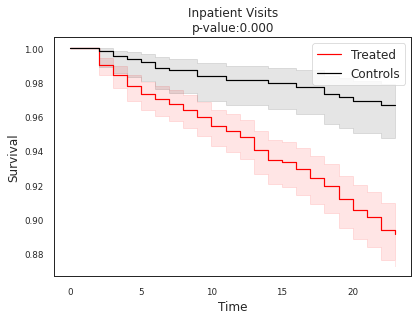

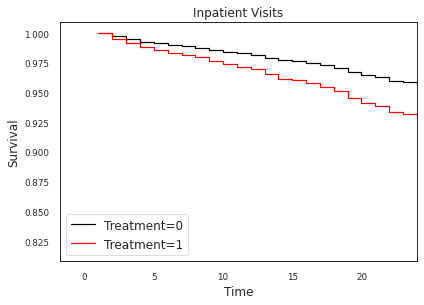

In [22]:
fitted, rmstIP = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type =model_type,
                          model_args = model_argsK,fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Inpatient Visits'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline,
                                      outcome_title = outcome_title)

In [23]:
lrsumm

test_statistic             p  -log2(p)
Inpatient Visits       24.042526  9.423131e-07  20.01729

In [24]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                  0.287           0.482        0.595    0.552
Gender               0.140           0.126        1.115    0.265
Total Cost           0.248           0.041        6.055    0.000
Tobacco use          0.436           0.153        2.856    0.004
Obesity             -0.349           0.136       -2.565    0.010
Hypertension        -0.108           0.153       -0.706    0.480
Hypothyroid         -0.158           0.183       -0.865    0.387
Disease Count        4.621           0.529        8.729    0.000
Treatment            0.514           0.165        3.113    0.002

### Acute Care IP OR ER

In [25]:
data = [treated,  controls]
for d in data:
    d['Acute-bin'] = ((d['ALLOW_ER'] > 0) | (d['ALLOW_IP'] > 0)).astype(int)

In [26]:
%%time
onset = 'Acute-bin'

survTr = treated.groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset).reset_index(drop = True)
survCo = controls.groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset).reset_index(drop = True)


CPU times: user 3.42 s, sys: 7.62 ms, total: 3.43 s
Wall time: 3.43 s


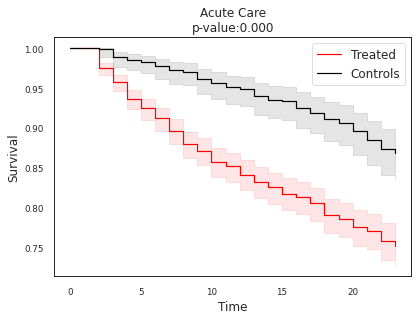

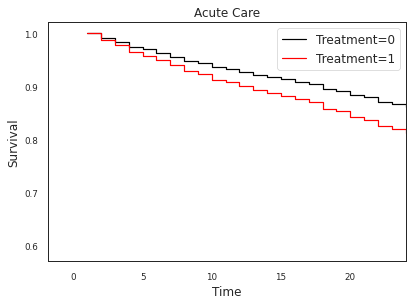

In [27]:
fitted, rmstAcute = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type = model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Acute Care'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                      timeline = timeline,
                                      outcome_title = outcome_title)

In [28]:
lrsumm

test_statistic             p   -log2(p)
Acute Care       37.382817  9.707363e-10  29.940202

In [29]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                 -1.446           0.293       -4.931    0.000
Gender              -0.144           0.082       -1.759    0.078
Total Cost           0.154           0.024        6.474    0.000
Tobacco use          0.550           0.101        5.471    0.000
Obesity             -0.298           0.091       -3.285    0.001
Hypertension        -0.097           0.099       -0.988    0.323
Hypothyroid         -0.237           0.130       -1.818    0.069
Disease Count        4.180           0.396       10.561    0.000
Treatment            0.326           0.102        3.209    0.001

### Load all Log Rank Sums in a matrix

In [30]:
from pathlib import Path
p = Path('./res/tabs')

df2 = None
for i, ff in enumerate(p.iterdir()):
    if ff.is_file() and ('lgrank' in ff.name):
        if i == 0:
            df2 = pd.read_csv(ff)
        else:
            df2 = pd.concat((df2, pd.read_csv(ff)), axis = 0, ignore_index = False)



df2.set_index(keys =['Unnamed: 0'] , inplace = True)
df2.index.name = ''
df2.columns = ['logRank statistic', 'p-value','a']
df2.drop(columns= ['a'], inplace = True)
df2.index = ['Diabetes', 'Emergency Visits', 'Inpatient Vistis', 'Acute Care']
df2['RMST difference'] = np.array([rmstD, rmstER, rmstIP, rmstAcute])
df2.round(3).to_csv('./res/tabs/all_logrank.csv')


In [31]:
df2

logRank statistic       p-value  RMST difference
Diabetes                  26.131477  3.189421e-07         0.476023
Emergency Visits          23.218970  1.445642e-06        -1.280001
Inpatient Vistis          24.042526  9.423131e-07        -0.857077
Acute Care                37.382817  9.707363e-10        -2.052793